# Analysis of clinical variatns of ORC1 protein

In [1]:
from clinvar_functions import *
import pandas as pd
import matplotlib.pyplot as plt

# Set option to display all rows
#pd.set_option('display.max_rows', None)

## ORC1 regions

In [15]:
# List of intervals for particular feature

#LLPS = [(360, 382), (412, 476), (577, 636), (677, 729), (757, 816)] # Chinees paper
#IDR_total = [(183, 476)] # Chinees paper
#G4_RNA = [(413, 511)] # Hoshina paper
#CDCD6=[(180, 240)] # CDC6 paper
#BP=[(354, 368), (378, 392)] # CDC6 paper
IDR = [(183, 511)]
RBD = [(413, 511)]

# Positions
IDR_pos = generate_list(IDR)
RBD_pos = generate_list(RBD)
# G4_RNA_positions = generate_list(G4_RNA)
# LLPS_positions = generate_list(LLPS)
# CDCD6_positions = generate_list(CDCD6)
# BP_positions = generate_list(BP)

## Read data

In [2]:
# Set option to display all rows and columns
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

df = pd.read_csv('clinvar_result.csv', sep = "\t")
df = df[df['Gene(s)'] == 'ORC1'] # save only ORC1 gene - delete 7 records
df.shape

(333, 25)

In [3]:
df.columns

Index(['Name', 'Gene(s)', 'Protein change', 'Condition(s)', 'Accession',
       'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome',
       'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID',
       'Canonical SPDI', 'Variant type', 'Molecular consequence',
       'Germline classification', 'Germline date last evaluated',
       'Germline review status', 'Somatic clinical impact',
       'Somatic clinical impact date last evaluated',
       'Somatic clinical impact review status', 'Oncogenicity classification',
       'Oncogenicity date last evaluated', 'Oncogenicity review status',
       'Unnamed: 24'],
      dtype='object')

In [19]:
# Keep only protein changes
#df = df.dropna(subset=["Protein change"])

## Look at the different columns of df

In [ ]:
df["Condition(s)"].value_counts()

In [ ]:
df["Germline classification"].value_counts()

In [ ]:
df['Germline review status'].value_counts()

## Get list of transcript IDs

In [4]:
IDs = df['Name'].apply(lambda x: x.split(":")[0])
IDs.value_counts()

Name
NM_004153.4(ORC1)       332
NM_001190818.1(ORC1)      1
Name: count, dtype: int64

## Add new column: Condition_new

In [5]:
df['Condition_new'] = df['Condition(s)'].map(rename_condition, na_action='ignore')

In [6]:
df['Condition_new'].value_counts()

Condition_new
not provided                        211
Meier-Gorlin syndrome 1 probably     42
Meier-Gorlin syndrome 1              30
Inborn genetic diseases              30
Inborn genetic diseases probably     12
ORC1-related disorder probably        6
Name: count, dtype: int64

# Non-coding mutations

In [7]:
sum(df["Protein change"].isna()) # no protein change

145

In [8]:
len(df["Protein change"]) # all variants

333

In [9]:
noncoding = df[df["Protein change"].isna()]

In [10]:
noncoding['Condition_new'].value_counts()

Condition_new
not provided                        115
Meier-Gorlin syndrome 1 probably     15
Meier-Gorlin syndrome 1               9
ORC1-related disorder probably        4
Inborn genetic diseases               1
Inborn genetic diseases probably      1
Name: count, dtype: int64

In [11]:
noncoding[noncoding['Condition_new'] == 'Meier-Gorlin syndrome 1'].groupby('Germline review status').size()

Germline review status
criteria provided, single submitter    8
no assertion criteria provided         1
dtype: int64

In [12]:
noncoding[noncoding['Condition_new'] == 'Meier-Gorlin syndrome 1 probably'].groupby('Germline review status').size()

Germline review status
criteria provided, conflicting classifications          8
criteria provided, multiple submitters, no conflicts    7
dtype: int64

In [20]:
# Subset of data from noncoding dataframe

# Filter the data for multiple conditions
MGS_non_coding_muts = noncoding[
    (noncoding['Condition_new'] == 'Meier-Gorlin syndrome 1') &
    (noncoding['Germline review status'] == 'criteria provided, single submitter')
][['GRCh38Location', 'Name', 'Condition_new', 'Accession']]

# Filter the data for multiple conditions
MGS_probable_non_coding_muts = noncoding[
    (noncoding['Condition_new'] == 'Meier-Gorlin syndrome 1 probably') &
    (noncoding['Germline review status'] == 'criteria provided, multiple submitters, no conflicts')
][['GRCh38Location', 'Name', 'Condition_new', 'Accession']]

In [31]:
# Create new column New_location
MGS_non_coding_muts["New_location"] = MGS_non_coding_muts['GRCh38Location'].apply(parse_location).astype(int).apply(lambda x: adjust_location(x, 52372828))
MGS_probable_non_coding_muts["New_location"] = MGS_probable_non_coding_muts['GRCh38Location'].apply(parse_location).astype(int).apply(lambda x: adjust_location(x, 52372828))

# Create new column New_name

MGS_non_coding_muts["New_name"] = MGS_non_coding_muts['Name'].apply(lambda x: x.split(":")[1])
MGS_probable_non_coding_muts["New_name"] = MGS_probable_non_coding_muts['Name'].apply(lambda x: x.split(":")[1])

In [35]:
MGS_non_coding_muts

,GRCh38Location,Name,Condition_new,Accession,New_location,New_name
0,52369376 - 52373623,NM_001190818.1(ORC1):c.2392-249_*3804del,Meier-Gorlin syndrome 1,VCV001173067,795,c.2392-249_*3804del
2,52372955,NM_004153.4(ORC1):c.*226G>C,Meier-Gorlin syndrome 1,VCV000297575,127,c.*226G>C
3,52373087,NM_004153.4(ORC1):c.*94C>T,Meier-Gorlin syndrome 1,VCV000297576,259,c.*94C>T
32,52373349,NM_004153.4(ORC1):c.2418C>T (p.Cys806=),Meier-Gorlin syndrome 1,VCV000874893,521,c.2418C>T (p.Cys806=)
182,52388541,NM_004153.4(ORC1):c.1284A>C (p.Thr428=),Meier-Gorlin syndrome 1,VCV000297584,15713,c.1284A>C (p.Thr428=)
277,52396332,NM_004153.4(ORC1):c.435G>A (p.Pro145=),Meier-Gorlin syndrome 1,VCV000297587,23504,c.435G>A (p.Pro145=)
280,52396366,NM_004153.4(ORC1):c.403-2A>C,Meier-Gorlin syndrome 1,VCV001323388,23538,c.403-2A>C
332,52402240,NM_004153.4(ORC1):c.-5-12A>T,Meier-Gorlin syndrome 1,VCV000875878,29412,c.-5-12A>T


# Non-coding variants visualization

Exons:
exon          	1..547        
exon          	1982..2069    
exon          	2602..2771    
exon          	8814..8933    
exon          	10.592..10.741
exon          	11.002..11.109
exon          	11.722..11.893
exon          	12.333..12.434
exon          	13.024..13.121
exon          	15.614..15.809
exon          	16.389..16.493
exon          	20.615..20.975
exon          	23.218..23.536


exon          	24.857..25.035
exon          	28.534..28.661

exon          	29.301..29.400
exon          	31.418..31.595

Gene length: 31595 bp
Positions: 52372829 - 52404423

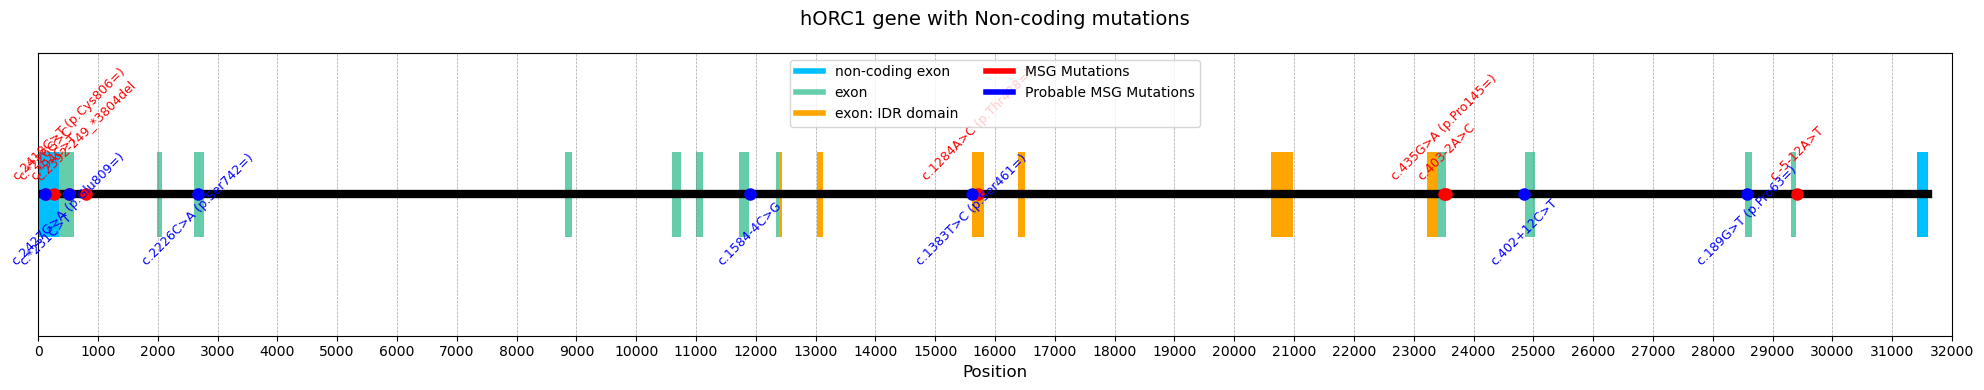

In [56]:
# Define protein information
protein_length = 31595  # Gene length
domains = [
    {"name": "non-coding exon", "start": 1, "end": 352, "color": "deepskyblue", "alpha": 1},
    {"name": "exon", "start": 353, "end": 597, "color": "mediumaquamarine", "alpha": 1},

    {"name": "exon", "start": 1982, "end": 2069, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 2602, "end": 2771, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 8814, "end": 8933, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 10592, "end": 10741, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 11002, "end": 11109, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 11722, "end": 11893, "color": "mediumaquamarine", "alpha": 1},

    # IDR end
    {"name": "exon", "start": 12333, "end": 12382, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 12383, "end": 12434, "color": "orange", "alpha": 1},

    {"name": "exon: IDR domain", "start": 13024, "end": 13121, "color": "orange", "alpha": 1},
    {"name": "exon: IDR domain", "start": 15614, "end": 15809, "color": "orange", "alpha": 1},
    {"name": "exon: IDR domain", "start": 16389, "end": 16493, "color": "orange", "alpha": 1},
    {"name": "exon: IDR domain", "start": 20615, "end": 20975, "color": "orange", "alpha": 1},
    
    # IDR start
    {"name": "exon: IDR domain", "start": 23218, "end": 23392, "color": "orange", "alpha": 1},
    {"name": "exon", "start": 23393, "end": 23536, "color": "mediumaquamarine", "alpha": 1},

    {"name": "exon", "start": 24857, "end": 25035, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 28534, "end": 28661, "color": "mediumaquamarine", "alpha": 1},

    {"name": "exon", "start": 29301, "end": 29396, "color": "mediumaquamarine", "alpha": 1},
    {"name": "non-coding exon", "start": 29397, "end": 29400, "color": "deepskyblue", "alpha": 1},

    {"name": "exon", "start": 31418, "end": 31595, "color": "deepskyblue", "alpha": 1}
]


# Create the figure
fig, ax = plt.subplots(figsize=(20, 4))

# Draw the protein backbone
ax.plot([0, protein_length], [0.5, 0.5], color="black", lw=6, label="Protein Backbone")

# Track unique labels for the legend
unique_labels = {}

# Draw the domains with labels
for domain in domains:
    label = f"{domain['name']}"
    if label not in unique_labels:
        unique_labels[label] = domain["color"]
    ax.barh(0.5, domain["end"] - domain["start"], left=domain["start"], height=0.3,
            color=domain["color"], alpha=domain["alpha"], label=None)  # Add label only for legend
    
# Plot mutations
for _, mutation in MGS_non_coding_muts.iterrows():
    ax.plot(
        mutation["New_location"],
        0.5,
        marker="o",
        color="red",
        markersize=8,
        label="Mutation" if _ == 0 else ""
    )
    ax.text(
        mutation["New_location"],
        0.55,
        mutation["New_name"],
        ha="center",
        fontsize=9,
        rotation=45,
        color="red"
    )

unique_labels["MSG Mutations"] = "red"
unique_labels["Probable MSG Mutations"] = "blue"

# Plot mutations
for _, mutation in MGS_probable_non_coding_muts.iterrows():
    ax.plot(
        mutation["New_location"],
        0.5,
        marker="o",
        color="blue",
        markersize=8,
        label="Mutation" if _ == 0 else ""
    )
    ax.text(
        mutation["New_location"],
        0.25,
        mutation["New_name"],
        ha="center",
        fontsize=9,
        rotation=45,
        color="blue"
    )



# Add the unique legend
ax.legend(handles=[plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in unique_labels.items()],
          loc="upper center", ncol=2, frameon=True, fontsize=10)

# Add gridlines for alignment
ax.grid(axis="x", color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# Add labels and title
ax.set_xlim(0, protein_length)
ax.set_ylim(0, 1)
ax.set_xticks(range(0, protein_length + 1000, 1000))
ax.set_yticks([])
ax.set_xlabel("Position", fontsize=12)
ax.set_title("hORC1 gene with Non-coding mutations", fontsize=14, pad=20)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Data
grouped_counts = noncoding.groupby("Germline review status")["Condition_new"].value_counts()
plot_data = grouped_counts.reset_index(name="Counts")
plot_data

# Pivot the data for better visualization
pivot_data = plot_data.pivot(index="Condition_new", columns="Germline review status", values="Counts")

# Plot as a bar chart
pivot_data.plot(kind="bar", figsize=(10, 8), edgecolor="black")

plt.title("Counts of Conditions by Germline Review Status for non-protein mutations", fontsize=14)
plt.xlabel("Condition", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Germline Review Status")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Filter the data for the specific condition
filtered_data = noncoding['Germline review status'][df["Condition_new"] =="Meier-Gorlin syndrome 1"]
# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
pie_chart = status_counts.plot.pie(
    labels=None,
    autopct='%1.1f%%',  # Show percentages
    startangle=90,      # Rotate start angle
    colors=['skyblue', 'lightgreen', 'orange'],  # Optional: specify colors
    wedgeprops={'edgecolor': 'black'},  # Add edge color
    title="Germline Review Status for Meier-Gorlin Syndrome 1 for non-protein mutations"
)
# Add a centered title
plt.title(
    "Germline Review Status for Meier-Gorlin Syndrome 1 for non-protein mutations", 
    loc="center",          # Explicitly center the title
    fontsize=14,           # Adjust font size for visibility
    pad=20                 # Add padding between the title and the chart
)

# Add a legend at the center right
plt.legend(
    labels=status_counts.index,  # Use the status names as labels
    title="Status",              # Add a title to the legend
    loc="center right",          # Position the legend at the center-right
    bbox_to_anchor=(1.50, 0.5),  # Offset for better alignment
)

plt.ylabel("")  # Remove default y-axis label
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

In [ ]:
# Filter the data for the specific condition
filtered_data = noncoding['Germline review status'][df["Condition_new"] =="Meier-Gorlin syndrome 1 probably"]
# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
status_counts.plot.pie(
    labels=None,
    autopct='%1.1f%%',  # Show percentages
    startangle=90,      # Rotate start angle
    colors=['skyblue', 'lightgreen', 'orange'],  # Optional: specify colors
    wedgeprops={'edgecolor': 'black'},  # Add edge color
    title="Germline Review Status for probable Meier-Gorlin Syndrome 1"
)
# Add a centered title
plt.title(
    "Germline Review Status for probable Meier-Gorlin Syndrome 1 for non-protein mutations", 
    ha="center",          # Explicitly center the title
    fontsize=14,           # Adjust font size for visibility
    pad=20
    )

# Add a legend at the center right
plt.legend(
    labels=status_counts.index,  # Use the status names as labels
    title="Status",              # Add a title to the legend
    loc="center right",          # Position the legend at the center-right
    bbox_to_anchor=(1.80, 0.5),  # Offset for better alignment
)

plt.ylabel("")  # Remove default y-axis label
plt.show()

# Visualisation

## Analyse Germline review status

In [ ]:
# Data
grouped_counts = df.groupby("Germline review status")["Condition_new"].value_counts()
plot_data = grouped_counts.reset_index(name="Counts")
plot_data

# Pivot the data for better visualization
pivot_data = plot_data.pivot(index="Condition_new", columns="Germline review status", values="Counts")

# Plot as a bar chart
pivot_data.plot(kind="bar", figsize=(10, 8), edgecolor="black")

plt.title("Counts of Conditions by Germline Review Status", fontsize=14)
plt.xlabel("Condition", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Germline Review Status")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Filter the data for the specific condition
filtered_data = df['Germline review status'][df["Condition_new"] =="Meier-Gorlin syndrome 1"]
# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
pie_chart = status_counts.plot.pie(
    labels=None,
    autopct='%1.1f%%',  # Show percentages
    startangle=90,      # Rotate start angle
    colors=['skyblue', 'lightgreen', 'orange'],  # Optional: specify colors
    wedgeprops={'edgecolor': 'black'},  # Add edge color
    title="Germline Review Status for Meier-Gorlin Syndrome 1"
)
# Add a centered title
plt.title(
    "Germline Review Status for Meier-Gorlin Syndrome 1", 
    loc="center",          # Explicitly center the title
    fontsize=14,           # Adjust font size for visibility
    pad=20                 # Add padding between the title and the chart
)

# Add a legend at the center right
plt.legend(
    labels=status_counts.index,  # Use the status names as labels
    title="Status",              # Add a title to the legend
    loc="center right",          # Position the legend at the center-right
    bbox_to_anchor=(1.50, 0.5),  # Offset for better alignment
)

plt.ylabel("")  # Remove default y-axis label
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

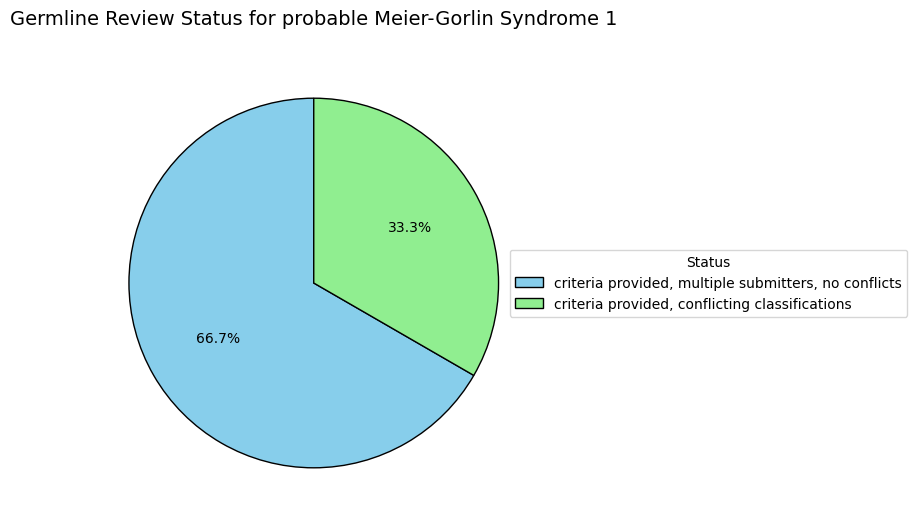

In [39]:
# Filter the data for the specific condition
filtered_data = df['Germline review status'][df["Condition_new"] =="Meier-Gorlin syndrome 1 probably"]
# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
status_counts.plot.pie(
    labels=None,
    autopct='%1.1f%%',  # Show percentages
    startangle=90,      # Rotate start angle
    colors=['skyblue', 'lightgreen', 'orange'],  # Optional: specify colors
    wedgeprops={'edgecolor': 'black'},  # Add edge color
    title="Germline Review Status for probable Meier-Gorlin Syndrome 1"
)
# Add a centered title
plt.title(
    "Germline Review Status for probable Meier-Gorlin Syndrome 1", 
    ha="center",          # Explicitly center the title
    fontsize=14,           # Adjust font size for visibility
    pad=20
    )

# Add a legend at the center right
plt.legend(
    labels=status_counts.index,  # Use the status names as labels
    title="Status",              # Add a title to the legend
    loc="center right",          # Position the legend at the center-right
    bbox_to_anchor=(1.80, 0.5),  # Offset for better alignment
)

plt.ylabel("")  # Remove default y-axis label
plt.show()

## Filtration: Meier-Gorlin syndrome 1 and probable Meier-Gorlin syndrome 1

Mutations that change amino acids. The picture of protein with domains.

In [40]:
MSG = df[
    (df["Condition_new"] == "Meier-Gorlin syndrome 1") &
    (df["Germline review status"] == "criteria provided, single submitter")
]
MSG.shape

(26, 26)

In [41]:
MSG_probably = df[
    (df["Condition_new"] == "Meier-Gorlin syndrome 1 probably") &
    (df["Germline review status"] == "criteria provided, multiple submitters, no conflicts")
]
MSG_probably.shape

(28, 26)

Number of variats is 18
Number of variats is 21


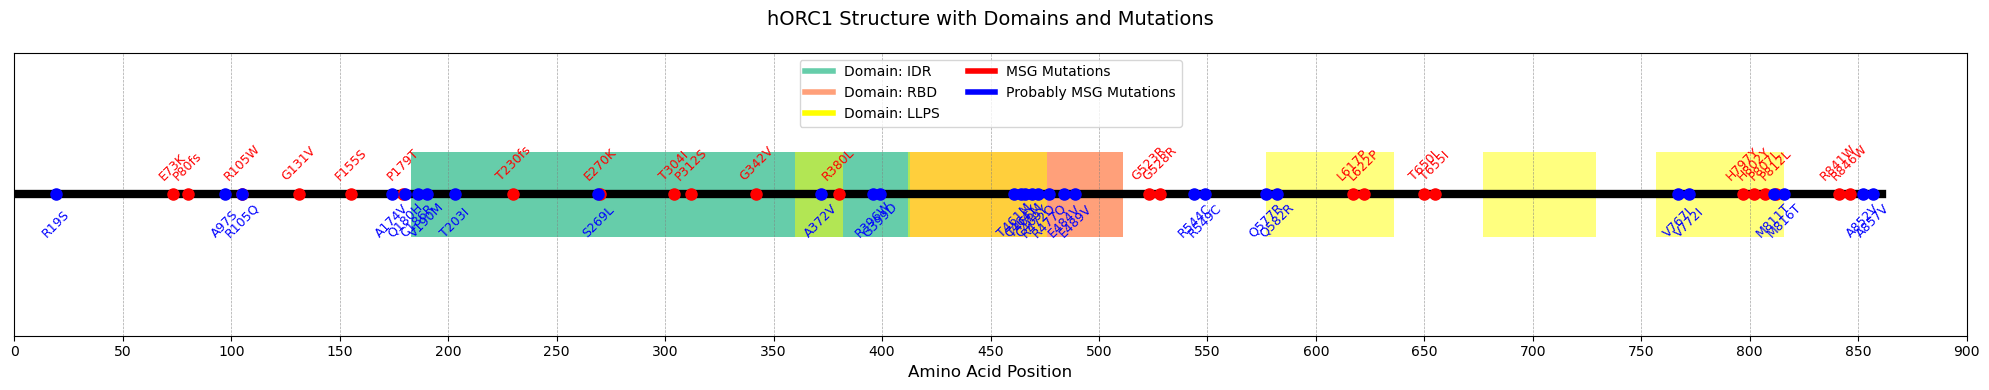

In [42]:
# Define protein information
protein_length = 861  # Protein length in amino acids
domains = [
    {"name": "IDR", "start": 183, "end": 413, "color": "mediumaquamarine", "alpha": 1},
    {"name": "RBD", "start": 413, "end": 511, "color": "lightsalmon", "alpha": 1},
    {"name": "LLPS", "start": 360, "end": 382, "color": "yellow", "alpha": 0.5},
    {"name": "LLPS", "start": 412, "end": 476, "color": "yellow", "alpha": 0.5},
    {"name": "LLPS", "start": 577, "end": 636, "color": "yellow", "alpha": 0.5},
    {"name": "LLPS", "start": 677, "end": 729, "color": "yellow", "alpha": 0.5},
    {"name": "LLPS", "start": 757, "end": 816, "color": "yellow", "alpha": 0.5}
]

mutations_MSG = create_mutation_dict(MSG)
mutations_MSG_probably = create_mutation_dict(MSG_probably)

# Create the figure
fig, ax = plt.subplots(figsize=(20, 4))

# Draw the protein backbone
ax.plot([0, protein_length], [0.5, 0.5], color="black", lw=6, label="Protein Backbone")

# Track unique labels for the legend
unique_labels = {}

# Draw the domains with labels
for domain in domains:
    label = f"Domain: {domain['name']}"
    if label not in unique_labels:
        unique_labels[label] = domain["color"]
    ax.barh(0.5, domain["end"] - domain["start"], left=domain["start"], height=0.3,
            color=domain["color"], alpha=domain["alpha"], label=None)  # Add label only for legend

# Mark the mutations for MSG (above the backbone)
for i, mutation in enumerate(mutations_MSG):
    if i == 0:
        unique_labels["MSG Mutations"] = "red"
    ax.plot(mutation["position"], 0.5, marker="o", color="red", markersize=8, label=None)
    ax.text(mutation["position"], 0.55, mutation["label"], ha="center", fontsize=9, rotation=45, color="red")

# Mark the mutations for MSG_probably (below the backbone)
for i, mutation in enumerate(mutations_MSG_probably):
    if i == 0:
        unique_labels["Probably MSG Mutations"] = "blue"
    ax.plot(mutation["position"], 0.5, marker="o", color="blue", markersize=8, label=None)
    ax.text(mutation["position"], 0.35, mutation["label"], ha="center", fontsize=9, rotation=45, color="blue")

# Add the unique legend
ax.legend(handles=[plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in unique_labels.items()],
          loc="upper center", ncol=2, frameon=True, fontsize=10)

# Add gridlines for alignment
ax.grid(axis="x", color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# Add labels and title
ax.set_xlim(0, protein_length)
ax.set_ylim(0, 1)
ax.set_xticks(range(0, protein_length + 50, 50))
ax.set_yticks([])
ax.set_xlabel("Amino Acid Position", fontsize=12)
ax.set_title("hORC1 Structure with Domains and Mutations", fontsize=14, pad=20)

# Show the plot
plt.tight_layout()
plt.show()


## List of mutations in every domain

In [ ]:
criterion = 'criteria provided, conflicting classifications'
disease = 'Meier-Gorlin syndrome 1'
protein_mut = df['Protein change'][(df['Germline review status'] == criterion) & (df['Condition_new']==disease)]
yes, no = mutation_analysis(protein_mut, RBD_pos)  

## Amino acids analysis

Analyse the percantage of Arginine (R) in different domains of ORC1 protein

In [ ]:
# Protein sequences
IDR = "AAKCQKPVRAKSKSAESPSWTPAEHVAKRIESRHSASKSRQTPTHPLTPRARKRLELGNLGNPQMSQQTSCASLDSPGRIKRKVAFSEITSPSKRSQPDKLQTLSPALKAPEKTRETGLSYTEDDKKASPEHRIILRTRIAASKTIDIREERTLTPISGGQRSSVVPSVILKPENIKKRDAKEAKAQNEATSTPHRIRRKSSVLTMNRIRQQLRFLGNSKSDQEEKEILPAAEISDSSSDEEEASTPPLPRRAPRTVSRNLRSSLKSSLHTLTKVPKKSLKPRTPRCAAPQIRS"
G4 = "AAEISDSSSDEEEASTPPLPRRAPRTVSRNLRSSLKSSLHTLTKVPKKSLKPRTPRCAAPQIRSRSLAAQEPASVLEEARLRLHVSAVPESLPCREQEF"
CDC6 = "QESAAKCQKPVRAKSKSAESPSWTPAEHVAKRIESRHSASKSRQTPTHPLTPRARKRLELG"
ORC="MAHYPTRLKTRKTYSWVGRPLLDRKLHYQTYREMCVKTEGCSTEIHIQIGQFVLIEGDDDENPYVAKLLELFEDDSDPPPKKRARVQWFVRFCEVPACKRHLLGRKPGAQEIFWYDYPACDSNINAETIIGLVRVIPLAPKDVVPTNLKNEKTLFVKLSWNEKKFRPLSSELFAELNKPQESAAKCQKPVRAKSKSAESPSWTPAEHVAKRIESRHSASKSRQTPTHPLTPRARKRLELGNLGNPQMSQQTSCASLDSPGRIKRKVAFSEITSPSKRSQPDKLQTLSPALKAPEKTRETGLSYTEDDKKASPEHRIILRTRIAASKTIDIREERTLTPISGGQRSSVVPSVILKPENIKKRDAKEAKAQNEATSTPHRIRRKSSVLTMNRIRQQLRFLGNSKSDQEEKEILPAAEISDSSSDEEEASTPPLPRRAPRTVSRNLRSSLKSSLHTLTKVPKKSLKPRTPRCAAPQIRSRSLAAQEPASVLEEARLRLHVSAVPESLPCREQEFQDIYNFVESKLLDHTGGCMYISGVPGTGKTATVHEVIRCLQQAAQANDVPPFQYIEVNGMKLTEPHQVYVQILQKLTGQKATANHAAELLAKQFCTRGSPQETTVLLVDELDLLWTHKQDIMYNLFDWPTHKEARLVVLAIANTMDLPERIMMNRVSSRLGLTRMCFQPYTYSQLQQILRSRLKHLKAFEDDAIQLVARKVAALSGDARRCLDICRRATEICEFSQQKPDSPGLVTIAHSMEAVDEMFSSSYITAIKNSSVLEQSFLRAILAEFRRSGLEEATFQQIYSQHVALCRMEGLPYPTMSETMAVCSHLGSCRLLLVEPSRNDLLLRVRLNVSQDDVLYALKDE"

# Calculations
ORC1_R = percantage_aa(seq=ORC, A="R")
IDR_R = percantage_aa(seq=IDR, A="R")
G4_R = percantage_aa(seq=G4, A="R")
CDC6_R = percantage_aa(seq=CDC6, A="R")

ORC1_G = percantage_aa(seq=ORC, A="G")
IDR_G = percantage_aa(seq=IDR, A="G")
G4_G = percantage_aa(seq=G4, A="G")
CDC6_G = percantage_aa(seq=CDC6, A="G")

print(f"Arginines in different ORC1 domains:")
print(f"ORC1: {ORC1_R} ; IDR: {IDR_R} ; G4 binding: {G4_R} ; CDC6 binding: {CDC6_R}")

print(f"Glycines in different ORC1 domains:")
print(f"ORC1: {ORC1_G} ; IDR: {IDR_G} ; G4 binding: {G4_G} ; CDC6 binding: {CDC6_G}")